In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDatasetWithActionEmbeds as SyntheticBanditDataset,
    linear_reward_function
)
from obp.ope import (
    OffPolicyEvaluation,
    InverseProbabilityWeighting as IPS,
)
from obp.utils import softmax

In [2]:
print(obp.__version__)

0.5.5


In [3]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_context = 10 # 特徴量xの次元
n_actions = 20 # 行動数, |A|
beta = 3 # 方策パラメータ
reward_std = 2 # 報酬のノイズの大きさ
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000] # オンライン実験で収集するデータのサイズ

In [4]:
se_df_list = []
for num_data in num_data_list:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),
        beta=beta,
        reward_type="continuous",
        reward_std=reward_std,
        reward_function=linear_reward_function,
        random_state=random_state,
    )
    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    value_of_pi = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=softmax(beta * test_data["expected_reward"])[:, :, np.newaxis]
    )

    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## オンライン実験で収集するログデータを、評価方策が形成する同時分布に従い生成
        online_experiment_data = dataset.obtain_batch_bandit_feedback(n_rounds=num_data)

        ## ログデータ上における方策の行動選択確率を計算
        pi = softmax(beta * online_experiment_data["expected_reward"])

        ## オンライン実験で収集したログデータを用いて推定を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=online_experiment_data,
            ope_estimators=[IPS(estimator_name="AVG")] # IPS推定量は、オンライン実験の設定においてはAVG推定量に一致する
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=value_of_pi, # V(\pi)
            action_dist=pi[:, :, np.newaxis], # \pi(a|x)
            metric="se", # squared error
        )
        se_list.append(squared_errors)

    ## シミュレーション結果を集計する
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
result_df_datasize = pd.concat(se_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 500/500 [00:27<00:00, 18.45it/s]


In [5]:
## 実験設定
num_data = 1000 # オンライン実験で収集するデータのサイズ
noise_list = [0, 2, 4, 6, 8, 10] # 報酬のノイズの大きさ

In [6]:
se_df_list = []
for noise in noise_list:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),
        beta=beta,
        reward_type="continuous",
        reward_std=noise,
        reward_function=linear_reward_function,
        random_state=random_state,
    )
    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    value_of_pi = dataset.calc_ground_truth_policy_value(
        expected_reward=test_bandit_data["expected_reward"],
        action_dist=softmax(beta * test_bandit_data["expected_reward"])[:, :, np.newaxis]
    )

    se_list = []
    for _ in tqdm(range(num_runs), desc=f"noise={noise}..."):
        ## オンライン実験で収集するログデータを生成
        online_experiment_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data,
        )

        ## ログデータ上における方策の行動選択確率を計算
        pi = softmax(beta * online_experiment_data["expected_reward"])

        ## オンライン実験で収集したログデータを用いて推定を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=online_experiment_data,
            ope_estimators=[IPS(estimator_name="AVG")] # IPS推定量は、オンライン実験の設定においてはAVG推定量に一致する
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=value_of_pi, # V(\pi)
            action_dist=pi[:, :, np.newaxis], # \pi(a|x)
            metric="se", # squared error
        )
        se_list.append(squared_errors)

    ## シミュレーション結果を集計する
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["noise"] = noise
    se_df_list.append(se_df)
result_df_noise = pd.concat(se_df_list).reset_index(level=0)

noise=10...: 100%|██████████| 500/500 [00:05<00:00, 97.63it/s] 


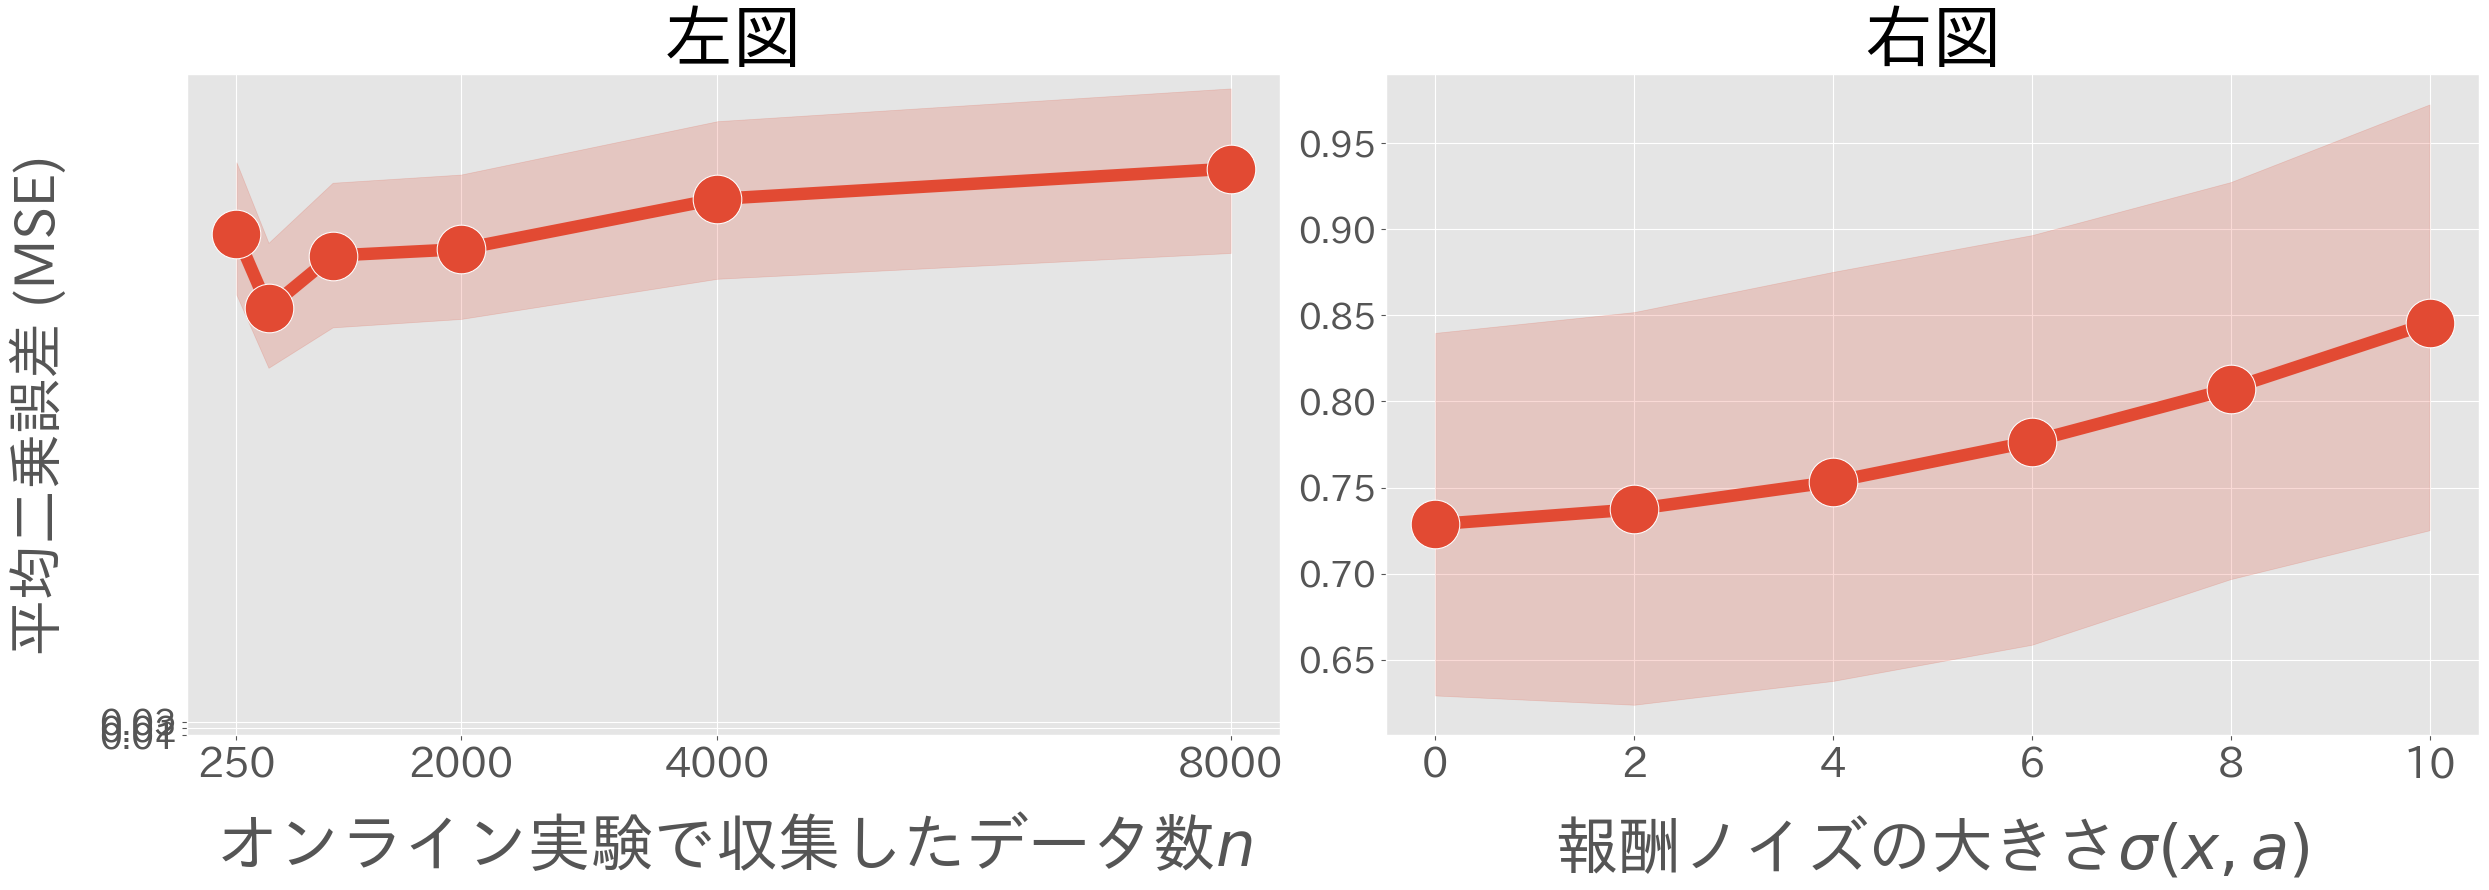

In [7]:
fig, ax_list = plt.subplots(1, 2, figsize=(25, 9), tight_layout=True)
x_dict, title_dict = {0: "num_data", 1: "noise"}, {0: "左図", 1: "右図"}
for i, result_df in enumerate([result_df_datasize, result_df_noise]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=35,
        linewidth=9,
        legend=False,
        style="est",
        x=x_dict[i],
        y="se",
        hue="est",
        ax=ax,
        data=result_df,
    )
    ax.set_title(title_dict[i], fontsize=50)
    if i == 0:
        ax.set_ylabel("平均二乗誤差 (MSE)", fontsize=40)
        ax.set_yticks([0.01, 0.02, 0.03])
        ax.set_yticklabels([0.01, 0.02, 0.03], fontsize=26)
        ax.yaxis.set_label_coords(-0.11, 0.5)
        ax.set_xlabel(r"オンライン実験で収集したデータ数$n$", fontsize=45)
        ax.set_xticks([250, 2000, 4000, 8000])
        ax.set_xticklabels([250, 2000, 4000, 8000], fontsize=30)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelsize=26)
        ax.set_xlabel(r"報酬ノイズの大きさ$\sigma(x,a)$", fontsize=45)
        ax.set_xticks([0, 2, 4, 6, 8, 10])
        ax.set_xticklabels([0, 2, 4, 6, 8, 10], fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)